<a href="https://colab.research.google.com/github/NeilCollinsMS/CTU-13-Classification/blob/main/CTU_13_Classification_(Aggregate).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CTU-13 Classification Project**

Aggregate Notebook (Each scenario combined and analyzed using train/test splits for validation)

There is an alternate notebook that was generated with per-scenario models (that you should not use because they are unrefined and flawed).

I am making use of Google Colab Pro ($10/mo) so that memory does not become an issue.

**The first several sections of this code are cleaning and prepping the balanced_df dataframe/csv. Model generation is labeled later.**

In [2]:
# Import Libraries - Same libraries utilized for per-scenario base models with a few additions to mount to Google Drive
import pandas as pd
import numpy as np
import os
import io
import eli5
import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics
from matplotlib import pyplot as plt
from google.colab import drive
from google.colab import files

# If you are running this notebook in Google Colab, the two you are most likely to be missing are eli5 and shap. Simply using !pip install package-name in another cell and you'll be up and running.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
!pip install eli5
!pip install shap

     |████████████████████████████████| 112kB 5.4MB/s 
     |████████████████████████████████| 358kB 6.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491638 sha256=eb1d858fab969d126c3a4d678bc5a16673d21a378341e95df359212c59301785
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


Time to aggregate all of the scenarios into one massive dataframe 

In [3]:
# Mounting google drive to this colab file. The file is too large to hold on my local host (3 GB), so storing it in drive is the easiest way to easily access it for future use.
drive.mount('/content/drive')
os.chdir("drive/My Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Checking that we're in the right place
os.getcwd()

'/content/drive/My Drive'

In [ ]:
# Only run these once to get the dataframes. The next steps will be to concat them into a master dataframe and then export that dataframe to a CSV to save session memory. 

scenario_1 = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-42/detailed-bidirectional-flow-labels/capture20110810.binetflow')
scenario_2 = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-43/detailed-bidirectional-flow-labels/capture20110811.binetflow')
scenario_3 = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-44/detailed-bidirectional-flow-labels/capture20110812.binetflow')
scenario_4 = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-45/detailed-bidirectional-flow-labels/capture20110815.binetflow')
scenario_5 = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-46/detailed-bidirectional-flow-labels/capture20110815-2.binetflow')
scenario_6 = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-47/detailed-bidirectional-flow-labels/capture20110816.binetflow')
scenario_7 = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-48/detailed-bidirectional-flow-labels/capture20110816-2.binetflow')
scenario_8 = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-49/detailed-bidirectional-flow-labels/capture20110816-3.binetflow')
scenario_9 = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-50/detailed-bidirectional-flow-labels/capture20110817.binetflow')
scenario_10 = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/detailed-bidirectional-flow-labels/capture20110818.binetflow')
scenario_11 = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-52/detailed-bidirectional-flow-labels/capture20110818-2.binetflow')
scenario_12 = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-53/detailed-bidirectional-flow-labels/capture20110819.binetflow')
scenario_13 = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-54/detailed-bidirectional-flow-labels/capture20110815-3.binetflow')

In [ ]:
# Combining each individual dataset into one master dataset (~2M records)
scenario_df = pd.concat([scenario_1, scenario_2, scenario_3, scenario_4, scenario_5, scenario_6, scenario_7, scenario_8, scenario_9, scenario_10, scenario_11, scenario_12, scenario_13], ignore_index = True)

In [ ]:
scenario_df.tail()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
19976695,2011/08/16 09:36:00.710103,0.000000,udp,147.32.84.229,13363,->,125.14.162.10,27460,INT,0.0,NaN,1,476,476,flow=Background-UDP-Attempt
19976696,2011/08/16 09:36:00.777160,0.000427,udp,213.146.167.54,20856,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,flow=Background-UDP-Established
19976697,2011/08/16 09:36:00.784094,0.000000,udp,147.32.84.229,13363,->,122.121.0.92,12923,INT,0.0,NaN,1,476,476,flow=Background-UDP-Attempt
19976698,2011/08/16 09:36:00.784160,0.000000,udp,147.32.84.229,13363,->,110.233.175.133,37690,INT,0.0,NaN,1,476,476,flow=Background-UDP-Attempt
19976699,2011/08/16 09:36:00.806547,0.000008,tcp,147.32.87.51,12489,->,147.32.86.96,49773,SA_,0.0,NaN,2,140,140,flow=Background-TCP-Established


In [ ]:
# Making a label column identifying the malicious IPs. These Malicious IPs were provided by the university that prepared the data.

scenario_df.loc[scenario_df['SrcAddr'] == '147.32.84.165', 'Malicious'] = 1
scenario_df.loc[scenario_df['SrcAddr'] == '147.32.84.191', 'Malicious'] = 1
scenario_df.loc[scenario_df['SrcAddr'] == '147.32.84.192', 'Malicious'] = 1
scenario_df.loc[scenario_df['SrcAddr'] == '147.32.84.193', 'Malicious'] = 1
scenario_df.loc[scenario_df['SrcAddr'] == '147.32.84.204', 'Malicious'] = 1
scenario_df.loc[scenario_df['SrcAddr'] == '147.32.84.205', 'Malicious'] = 1
scenario_df.loc[scenario_df['SrcAddr'] == '147.32.84.206', 'Malicious'] = 1
scenario_df.loc[scenario_df['SrcAddr'] == '147.32.84.207', 'Malicious'] = 1
scenario_df.loc[scenario_df['SrcAddr'] == '147.32.84.208', 'Malicious'] = 1
scenario_df.loc[scenario_df['SrcAddr'] == '147.32.84.209', 'Malicious'] = 1
scenario_df.loc[scenario_df['Malicious'] != 1, 'Malicious'] = 0

In [ ]:
# Checking that the malicious column worked properly

display(scenario_df.loc[scenario_df['SrcAddr'] == '147.32.84.165'].head())
display(scenario_df.head())

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Malicious
675537,2011/08/10 11:04:24.863449,0.000278,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,203,64,flow=From-Botnet-V42-UDP-DNS,1.0
675872,2011/08/10 11:04:27.118993,0.020525,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,590,87,flow=From-Botnet-V42-UDP-DNS,1.0
675877,2011/08/10 11:04:27.140727,0.045125,tcp,147.32.84.165,1027,->,74.125.232.195,80,SRPA_SPA,0.0,0.0,7,882,629,flow=From-Botnet-V42-TCP-HTTP-Google-Net-Estab...,1.0
689920,2011/08/10 11:06:23.268442,0.336250,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,215,71,flow=From-Botnet-V42-UDP-DNS,1.0
689955,2011/08/10 11:06:23.606888,3514.083496,tcp,147.32.84.165,1039,->,60.190.222.139,65520,SPA_SPA,0.0,0.0,120,7767,2690,flow=From-Botnet-V42-TCP-Established,1.0


,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Malicious
0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,<->,147.32.84.229,13363,CON,0.0,0.0,12,875,413,flow=Background-UDP-Established,0.0
1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,flow=Background-UDP-Established,0.0
2,2011/08/10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,flow=Background,0.0
3,2011/08/10 09:46:53.053771,0.056966,tcp,83.3.77.74,32882,<?>,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,flow=Background,0.0
4,2011/08/10 09:46:53.053937,3427.768066,udp,74.89.223.204,21278,<->,147.32.84.229,13363,CON,0.0,0.0,42,2856,1596,flow=Background-UDP-Established,0.0


In [ ]:
# Checking the unique state values. Too many to one-hot encode, not worth it for now.

scenario_df.State.unique()

array(['CON', 'FA_A', 'FA_FA', 'PA_PA', 'FPA_FRPA', 'FPA_RPA',
       'FSPA_FSPA', 'PA_A', 'FA_RA', 'PA_FRA', 'FRPA_FPA', 'FPA_FA', 'A_',
       'INT', 'FA_', 'S_SA', 'RPA_RPA', 'FPA_FPA', 'PA_RPA', 'FSPA_FSRPA',
       'S_', 'SA_R', 'SRPA_SPA', 'SRA_SA', 'FPA_', 'RPA_PA', 'URP',
       'SRPA_FSRPA', 'FRPA_PA', 'URN', 'PA_', 'FA_FPA', 'SPA_FSPA',
       'PA_FRPA', 'PA_PAC', 'PA_FPA', 'FSRPA_FSPA', 'FRPA_RA', 'TXD',
       'RA_FA', 'FRA_', 'ECO', 'FRA_FPA', 'SRPA_FSPA', 'URH', 'SA_',
       'SRPA_SRA', 'FSA_FSA', 'RPA_FPA', 'FSRPA_SPA', 'S_RA', 'PA_R',
       'RA_A', 'RED', 'RA_', 'SPA_SRPA', 'FA_R', 'RA_FPA', 'A_PA', 'ECR',
       'FSPA_FSRA', 'SPA_SPA', 'FSRPA_FSRPA', 'SRA_FSA', 'FPA_PA',
       'SR_SA', 'FRPA_RPA', 'FPA_RA', 'FPA_FRA', 'FSPA_FSA', 'FRA_FA',
       'URFIL', '_FSPA', 'R_', 'FA_FRPA', 'SPA_FSRPA', 'FA_FRA',
       'RPA_FRPA', 'RPA_R', 'A_A', 'A_RA', 'SRPA_SA', 'SRA_RA',
       'FSPA_SPA', 'RPAC_PA', 'SPA_SRA', 'FSPAC_FSPA', 'PA_RA', 'FRPA_FA',
       'SR_A', 'A_R', 'SRP

In [ ]:
# This is a very bulky dataframe, to save space I am going to drop any columns that I do not plan to utilize in the models.

scenario_df.drop(['StartTime', 'SrcAddr', 'Sport', 'Dir', 'DstAddr', 'Dport', 'State', 'sTos', 'dTos', 'Label'], axis = 1, inplace = True)

In [ ]:
scenario_df

,Dur,Proto,TotPkts,TotBytes,SrcBytes,Malicious
0,3550.182373,udp,12,875,413,0.0
1,0.000883,udp,2,135,75,0.0
2,0.000326,tcp,2,120,60,0.0
3,0.056966,tcp,3,180,120,0.0
4,3427.768066,udp,42,2856,1596,0.0
...,...,...,...,...,...,...
19976695,0.000000,udp,1,476,476,0.0
19976696,0.000427,udp,2,135,75,0.0
19976697,0.000000,udp,1,476,476,0.0
19976698,0.000000,udp,1,476,476,0.0


In [ ]:
# Saving the scenarios dataframe to my drive for easy access in the future. I will likely do this for the training/testing data splits later on as well so I don't have to pull this goliath dataset every time I want to train. 

with open('/content/drive/My Drive/scenarios.csv', 'w') as f:
  scenario_df.to_csv(f, header = True, index = False)

In [ ]:
# Reading in the saved CSV from my drive. Remember to mount the drive to notebook each time you run it.

scenarios = pd.read_csv('scenarios.csv', error_bad_lines=False, index_col=False, dtype='unicode')

In [ ]:
scenarios

,Dur,Proto,TotPkts,TotBytes,SrcBytes,Malicious
0,3550.1823729999996,udp,12,875,413,0.0
1,0.000883,udp,2,135,75,0.0
2,0.00032599999999999996,tcp,2,120,60,0.0
3,0.056965999999999996,tcp,3,180,120,0.0
4,3427.7680659999996,udp,42,2856,1596,0.0
...,...,...,...,...,...,...
19976695,0.0,udp,1,476,476,0.0
19976696,0.00042699999999999997,udp,2,135,75,0.0
19976697,0.0,udp,1,476,476,0.0
19976698,0.0,udp,1,476,476,0.0


In [ ]:
# Time for one hot encoding of Proto. Usually I'd do this before making a permanent file, but just running the setup files eats most of a colab session worth of memory, so this will have to do

Proto_dummy = pd.get_dummies(scenarios.Proto)

# Combining the dummy frame with the original data frame
scenarios = pd.concat([scenarios, Proto_dummy], axis = 1)
scenarios

,Dur,Proto,TotPkts,TotBytes,SrcBytes,Malicious,arp,esp,gre,icmp,igmp,ipnip,ipv6,ipv6-icmp,ipx/spx,llc,pim,rarp,rsvp,rtcp,rtp,tcp,udp,udt,unas
0,3550.1823729999996,udp,12,875,413,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.000883,udp,2,135,75,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.00032599999999999996,tcp,2,120,60,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.056965999999999996,tcp,3,180,120,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,3427.7680659999996,udp,42,2856,1596,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19976695,0.0,udp,1,476,476,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
19976696,0.00042699999999999997,udp,2,135,75,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
19976697,0.0,udp,1,476,476,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
19976698,0.0,udp,1,476,476,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Dropping the protocol column where the dummy encoding was generated from

scenarios.drop(['Proto'], axis = 1, inplace = True)

In [ ]:
# Saving the updated dummy encoded dataframe 

with open('/content/drive/My Drive/scenarios_1h.csv', 'w') as f:
  scenarios.to_csv(f, header = True, index = False)

In [ ]:
# Reading the new dataframe
scenarios_1h = pd.read_csv('scenarios_1h.csv', error_bad_lines=False, index_col=False, dtype='unicode')

In [ ]:
scenarios_1h.head()

,Dur,TotPkts,TotBytes,SrcBytes,Malicious,arp,esp,gre,icmp,igmp,ipnip,ipv6,ipv6-icmp,ipx/spx,llc,pim,rarp,rsvp,rtcp,rtp,tcp,udp,udt,unas
0,3550.1823729999996,12,875,413,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.000883,2,135,75,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.00032599999999999996,2,120,60,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.056965999999999996,3,180,120,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,3427.7680659999996,42,2856,1596,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


**Balancing the target feature**

In [ ]:
# Setting the target

y = scenarios_1h.Malicious

# Counting how many malicious IP instances are in the dataset

target_counts = y.value_counts()
num_ones = target_counts[1]
print(num_ones)

444636


In [ ]:
# Extracting the malicious units

ones = scenarios_1h[scenarios_1h['Malicious'] == '1.0']

# Extracting the non-malicious records

zeroes = scenarios_1h[scenarios_1h['Malicious'] == '0.0']

In [ ]:
# Taking a random sample of non-malicious units equal to the number of malicious records

zeroes_sample = zeroes.sample(n=len(ones))

# Ensuring that the data is balanced between malicious and non malicious data

print(f'Num zeroes: {len(zeroes_sample)}')
print(f'Num ones: {len(ones)}')

Num zeroes: 444636
Num ones: 444636


In [ ]:
# Combining the malicious IP records with the non malicious sample

balanced_df = pd.concat([ones, zeroes.sample(n=len(ones), replace=True)])

In [ ]:
# Confirming proper concat

print(balanced_df['Malicious'].value_counts())

0.0    444636
1.0    444636
Name: Malicious, dtype: int64


In [ ]:
# Saving the final dataframe as a CSV

with open('/content/drive/My Drive/balanced_df.csv', 'w') as f:
  balanced_df.to_csv(f, header = True, index = False)

**Here is where the modeling actually begins**

In [4]:
# Reading the final csv to a dataframe

balanced_df = pd.read_csv('balanced_df.csv', error_bad_lines=False, index_col=False, dtype='unicode')

In [8]:
balanced_df.head()

,Dur,TotPkts,TotBytes,SrcBytes,Malicious,arp,esp,gre,icmp,igmp,ipnip,ipv6,ipv6-icmp,ipx/spx,llc,pim,rarp,rsvp,rtcp,rtp,tcp,udp,udt,unas
0,0.000278,2,203,64,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.020525,2,590,87,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.045125,7,882,629,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.33625,2,215,71,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,3514.083496,120,7767,2690,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [5]:
# Setting target

y = balanced_df.Malicious

# Setting predictive features

features = ['Dur', 'TotPkts', 'TotBytes', 'SrcBytes', 'arp', 'esp', 'gre', 'icmp', 'igmp', 'ipnip', 'ipv6', 'ipv6-icmp', 'ipx/spx', 'llc', 'pim', 'rarp', 'rsvp', 'rtcp', 'rtp', 'tcp', 'udp', 'udt', 'unas']
X = balanced_df[features].copy()

In [6]:
# 80/20 train test split

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 1)

In [ ]:
# Defining an f1 testing function

def get_f1(max_leaf_nodes, X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    f1 = f1_score(y_test, predictions, pos_label = '1.0')
    return(f1)

In [ ]:
# Finding the optimal leaf nodes for f1 score

for max_leaf_nodes in [5, 50, 500, 5000]:
    my_f1 = get_f1(max_leaf_nodes, X_train, X_test, y_train, y_test)
    print(max_leaf_nodes, my_f1)

5 0.7738615509771647
50 0.9146942829429224
500 0.9497373833523143
5000 0.9647219822992967


In [ ]:
# Defining a roc_auc testing function

def get_roc_auc(max_leaf_nodes, X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions)
    return(roc_auc)


In [ ]:
# Finding optimal max leaf nodes by roc_auc

for max_leaf_nodes in [5, 50, 500, 5000]:
    my_roc_auc = get_roc_auc(max_leaf_nodes, X_train, X_test, y_train, y_test)
    print(max_leaf_nodes, my_roc_auc)

5 0.7986040692553122
50 0.9174901655836563
500 0.9501417486984085
5000 0.9646330305380658


GridSearchCV was another way that I could search for the optimal parameters, but given the very solid roc_auc and f1 scores seen here, I do not believe it is necessary, but for optimal model performance you would want to take the time.

https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

A faster method to finding optimal parameters would be to utilize RandomizedSearchCV. If the initial results weren't so promising, we would make use of search functions to optimize the model.

In [7]:
#Increasing leaf nodes to 5000 would have marginal benefits for the model's f1 and roc_auc, but the runtime difference is not worth it for this specific toy example.

classifier_1 = RandomForestClassifier(max_leaf_nodes=500, random_state = 1)

classifier_1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=500, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

**Model Validation Metrics**


In [ ]:
# Generating predictions

predictions = classifier_1.predict(X_test)

# Accuracy score

accuracy_score(y_test, predictions)

0.9501222906300076

In [ ]:
# f1 score

f1_score(y_test, predictions, pos_label = '1.0')

0.9497373833523143

In [ ]:
# ROC AUC

roc_auc_score(y_test, predictions)

0.9501417486984085

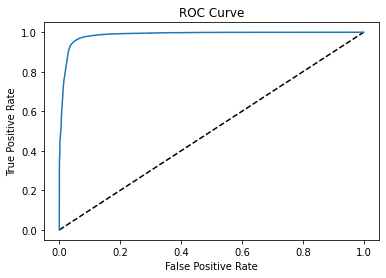

In [ ]:
# Plotting the ROC curve for our viewing pleasure

y_pred_prob = classifier_1.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label='1.0')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
# Generating confusion matrix to view true and false positive counts

labels = np.unique(y_test)
cm = confusion_matrix(y_test, predictions, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

,0.0,1.0
0.0,85173,3574
1.0,5297,83811


**Exploring the Black Box**

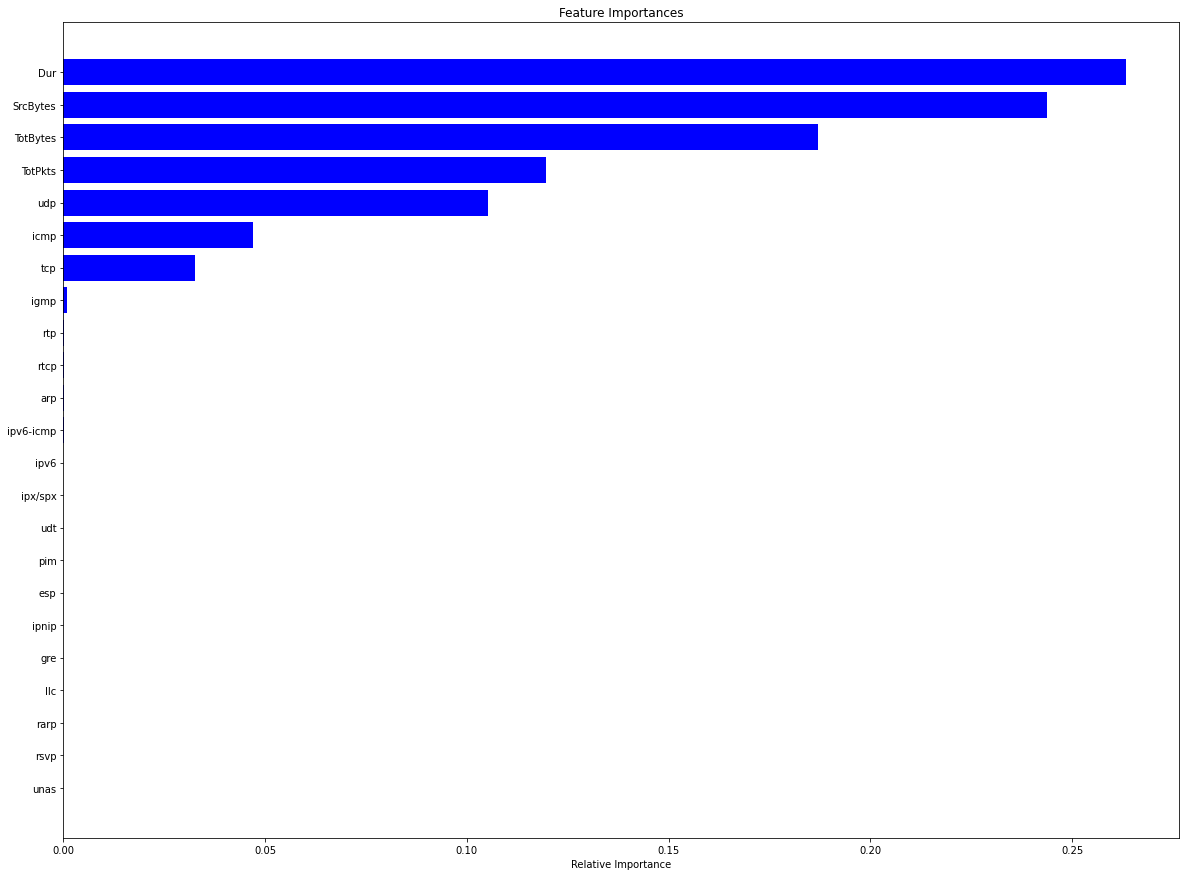

In [ ]:
# Graphing feature importance

importances = classifier_1.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Permutation importance shuffles each individual column's values, leaving all other features in place to see what sort of impact it has on the target. 
# In this instance, SrcBytes, Dur, TotBytes, UDP, etc... have the largest importance towards predicting malicious IPs, while something like ipv6 has less importance.

perm = PermutationImportance(classifier_1, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())


Weight,Feature
0.3590 ± 0.0009,SrcBytes
0.2457 ± 0.0012,Dur
0.1693 ± 0.0004,TotBytes
0.1507 ± 0.0005,udp
0.1298 ± 0.0008,icmp
0.0897 ± 0.0007,TotPkts
0.0790 ± 0.0003,tcp
0.0000 ± 0.0000,igmp
0.0000 ± 0.0000,rtp
0.0000 ± 0.0000,rtcp


In [12]:
# SHAP explainer for a single row of data
row_to_show = 5
prediction_data = X_test.iloc[row_to_show]
prediction_data_array = prediction_data.values.reshape(1,-1)

classifier_1.predict_proba(prediction_data_array)

array([[0.72581571, 0.27418429]])

In [13]:
explainer = shap.TreeExplainer(classifier_1)
shap_values = explainer.shap_values(prediction_data)

"The shap_values object above is a list with two arrays. The first array is the SHAP values for a negative outcome (don't win the award), and the second array is the list of SHAP values for the positive outcome (wins the award). We typically think about predictions in terms of the prediction of a positive outcome, so we'll pull out SHAP values for positive outcomes (pulling out shap_values[1])."

per https://www.kaggle.com/dansbecker/shap-values

For our purposes, this applies to malicious and non malicious IPs.

In [ ]:
# SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction that would be made if that feature took some baseline value.
# This visual shows that TotPkts, TotBytes, Dur, SrcBytes, and udp have the greatest impact on the predictions (this lines up very nicely with our permutation importance)
# TotPkts being equal to 412 and TotBytes being equal to 2 increase the prediction value, and the largest impacts come from Dur being 0.000647 and SrcBytes being 83.

shap.initjs() # This trusts javascript
shap.force_plot(explainer.expected_value[1], shap_values[1], prediction_data)

In [ ]:
# This is an approximation of the previous plot using kernel explainer. Kernel SHAP is a method that uses a special weighted linear regression to compute the importance of each feature. Less accurate, but roughly the same story.

k_explainer = shap.KernelExplainer(classifier_1.predict_proba, shap.sample(X_train, 5))
k_shap_values = k_explainer.shap_values(prediction_data)
shap.initjs() # This trusts javascript
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], prediction_data)

In [8]:
# SHAP Summary plot needs to run on a small sample of the testing data. (The X_test dataframe is far too large to run this against in a timely manner)

explainer = shap.TreeExplainer(classifier_1)
X_test_sample = X_test.sample(frac=0.05, replace=False, random_state=1)

In [9]:
X_test_sample.dtypes

Dur          object
TotPkts      object
TotBytes     object
SrcBytes     object
arp          object
esp          object
gre          object
icmp         object
igmp         object
ipnip        object
ipv6         object
ipv6-icmp    object
ipx/spx      object
llc          object
pim          object
rarp         object
rsvp         object
rtcp         object
rtp          object
tcp          object
udp          object
udt          object
unas         object
dtype: object

In [10]:
# Coercing features to numeric to make sure shap.summary_plot colors properly

X_test_sample = X_test_sample.apply(pd.to_numeric, errors='coerce')

In [11]:
X_test_sample.dtypes

Dur          float64
TotPkts        int64
TotBytes       int64
SrcBytes       int64
arp            int64
esp            int64
gre            int64
icmp           int64
igmp           int64
ipnip          int64
ipv6           int64
ipv6-icmp      int64
ipx/spx        int64
llc            int64
pim            int64
rarp           int64
rsvp           int64
rtcp           int64
rtp            int64
tcp            int64
udp            int64
udt            int64
unas           int64
dtype: object

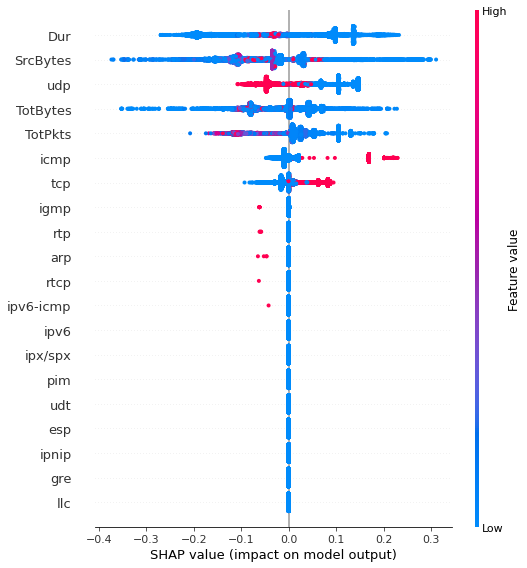

In [12]:
shap_values = explainer.shap_values(X_test_sample)
shap.summary_plot(shap_values[1], X_test_sample)

**Gaussian Naive Bayes**

Note: In the future, normalize all arrays to floats to ensure no conversion errors.

In [ ]:
classifier_2 = GaussianNB()
pred = classifier_2.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
  % (X_test.shape[0], (y_test != pred).sum()))

Number of mislabeled points out of a total 177855 points : 80636


In [ ]:
accuracy_score(y_test, pred)

0.546619437181974

In [ ]:
f1_score(y_test, pred, pos_label = '1.0')

0.6826129055112532

In [ ]:
pred = pred.astype(np.float64)
roc_auc_score(y_test, pred)

0.5457519847228985

In [ ]:
y_test = y_test.astype(np.float64)
labels = np.unique(y_test)
cm = confusion_matrix(y_test, pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

,0.0,1.0
0.0,10506,78241
1.0,2395,86713


Across the board, Random Forest algorithms are generating better values. There are some apparent issues here (e.g. Naive Bayes confusion matrix does not include every test value). Considering the very high values given by the Random Forest classifier(accuracy, roc_auc, and f1 all at or above 0.95), I do not 
deem it necessary to further improve this model.